# AI-Powered URL Phishing Detection System
# Random Forest Classifier for Browser Extension

## Steup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import os
import re
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration and Logging

### Set up logging

In [3]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [4]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/browser_extension_features_v2.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/random_forest_model/random_forest_model.pkl'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/random_forest_training_log.json'

### Create directories if they don't exist

In [5]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Data Loading and Exploration

### Load dataset

In [6]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

try:
    df = pd.read_csv(RAW_DATA_PATH)
    if 'class' not in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        print(f"Converting string labels to numeric. Unique values: {df['class'].unique()}")
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Class values after conversion: {df['class'].unique()}")
    print(f"Class distribution: {df['class'].value_counts()}")

    log_event("DATA_LOADED", f"Dataset loaded with shape {df.shape}",
              {"rows": df.shape[0], "columns": df.shape[1]})
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-04-27T14:34:30.710629] DATA_LOADING: Loading dataset
Class values after conversion: [1 0]
Class distribution: class
1    10000
0    10000
Name: count, dtype: int64
[2025-04-27T14:34:30.937799] DATA_LOADED: Dataset loaded with shape (20000, 2)
[2025-04-27T14:34:30.937943] TIMING: Data loading completed in 0.23 seconds


### Display basic information about the dataset

In [7]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 20000
Features: 2

Data Types:
URL      object
class     int64
dtype: object

Class Distribution:
class
1    10000
0    10000
Name: count, dtype: int64

First 5 rows:
                                      URL  class
0                 http://www.teramill.com      1
1             http://www.f0519141.xsph.ru      1
2                http://www.shprakserf.gq      1
3  https://service-mitld.firebaseapp.com/      1
4       http://www.kuradox92.lima-city.de      1


## 2. Feature Extraction for Browser Extension


This section extracts lightweight features suitable for a browser-based phishing detection extension.
We focus on URL characteristics that can be quickly computed in a browser environment.


In [8]:
log_event("FEATURE_EXTRACTION", "Extracting lightweight features for browser extension")
start_time = time.time()

[2025-04-27T14:34:37.995663] FEATURE_EXTRACTION: Extracting lightweight features for browser extension


Extract lightweight features suitable for browser extension:
  - URL Length
  - Number of dots in domain
  - Number of special characters
  - Presence of IP address
  - Presence of @ symbol
  - Number of subdomains
  - Use of HTTPS
  - Presence of hyphens in domain
  - URL shortener detection
    
These features should be fast to compute in a browser extension


In [9]:
def extract_lightweight_features(urls_df):
    features_df = pd.DataFrame()

    # URL Length
    features_df['url_length'] = urls_df['URL'].apply(len)

    # Number of dots in domain
    features_df['num_dots'] = urls_df['URL'].apply(lambda x: x.count('.'))

    # Number of special characters (!@#$%^&*()_+)
    features_df['num_special_chars'] = urls_df['URL'].apply(
        lambda x: sum(c in "!@#$%^&*()_+-=[]{}|;:,<>?/" for c in x))

    # Presence of IP address (simple check for 4 numbers separated by dots)
    features_df['has_ip'] = urls_df['URL'].apply(
        lambda x: 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', x)) else 0)

    # Presence of @ symbol
    features_df['has_at_symbol'] = urls_df['URL'].apply(lambda x: '@' in x).astype(int)

    # Number of subdomains
    features_df['num_subdomains'] = urls_df['URL'].apply(
        lambda x: len(re.findall(r'\.', x.split('/')[2])) if len(x.split('/')) > 2 else 0)

    # Use of HTTPS
    features_df['has_https'] = urls_df['URL'].apply(lambda x: x.startswith('https')).astype(int)

    # Presence of hyphens in domain
    features_df['has_hyphen'] = urls_df['URL'].apply(
        lambda x: '-' in x.split('/')[2] if len(x.split('/')) > 2 else 0).astype(int)

    # URL shortener detection (common URL shorteners)
    url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly']
    features_df['is_shortened'] = urls_df['URL'].apply(
        lambda x: any(shortener in x for shortener in url_shorteners)).astype(int)

    # Add the target class from original dataset
    features_df['is_phishing'] = urls_df['class']

    return features_df

### Extract features

In [10]:
browser_features = extract_lightweight_features(df)

### Display sample of extracted features

In [11]:
print("\nExtracted Features (First 5 rows):")
print(browser_features.head())


Extracted Features (First 5 rows):
   url_length  num_dots  num_special_chars  has_ip  has_at_symbol  \
0          23         2                  3       0              0   
1          27         3                  3       0              0   
2          24         2                  3       0              0   
3          38         2                  5       0              0   
4          33         3                  4       0              0   

   num_subdomains  has_https  has_hyphen  is_shortened  is_phishing  
0               2          0           0             0            1  
1               3          0           0             0            1  
2               2          0           0             0            1  
3               2          1           1             0            1  
4               3          0           1             0            1  


### Save the processed features

In [12]:
browser_features.to_csv(PROCESSED_DATA_PATH, index=False)

feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": browser_features.shape[1] - 1})

[2025-04-27T14:34:48.221518] TIMING: Feature extraction completed in 10.23 seconds


## 3. Model Training

This section trains a Random Forest classifier on our extracted features.
Random Forest is chosen for its good performance on classification tasks
and ability to handle non-linear relationships.

In [13]:
log_event("MODEL_TRAINING", "Starting model training with Random Forest")
start_time = time.time()

[2025-04-27T14:34:50.649220] MODEL_TRAINING: Starting model training with Random Forest


### Prepare features and target

In [14]:
X = browser_features.drop('is_phishing', axis=1)
y = browser_features['is_phishing']

### Split data (80-20 split)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [16]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-04-27T14:35:00.580528] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train model

In [18]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-04-27T14:35:05.914675] TIMING: Model training completed in 15.27 seconds


## 4. Model Evaluation

This section evaluates our trained model using standard classification metrics:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall
- AUC: Area under the ROC curve

In [19]:
log_event("MODEL_EVALUATION", "Evaluating Random Forest model")
start_time = time.time()

[2025-04-27T14:35:08.328755] MODEL_EVALUATION: Evaluating Random Forest model


### Make predictions

In [20]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)

### ROC curve and AUC

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [23]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": roc_auc
})

[2025-04-27T14:35:15.663011] EVALUATION_METRICS: Model performance metrics


### Print model performance

In [24]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9910
Precision: 0.9925
Recall: 0.9895
F1 Score: 0.9910
AUC: 0.9963


## 5. Visualization of Results

This section visualizes key aspects of our model performance:
- Confusion Matrix: Shows the true positive, false positive, true negative, and false negative counts
- ROC Curve: Shows the trade-off between sensitivity and specificity
- Feature Importance: Shows which features are most influential in the model's predictions

### Plot confusion matrix

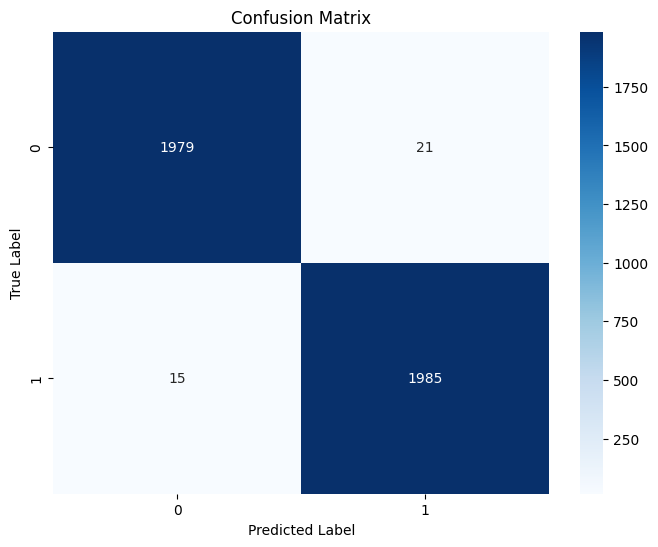

In [25]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

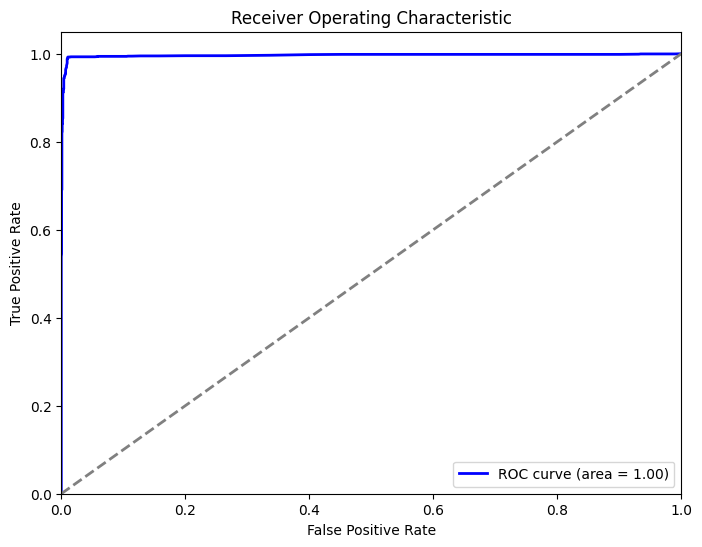

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

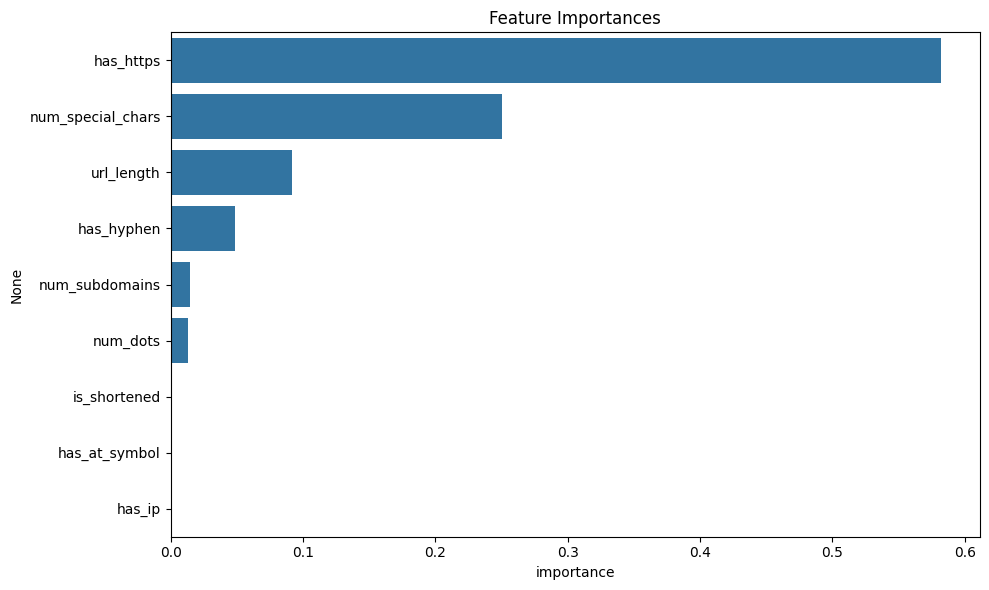

[2025-04-27T14:35:29.823905] TIMING: Model evaluation completed in 21.49 seconds


In [27]:
feature_importances = pd.DataFrame(
    rf_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

## 6. Model Saving

This section saves the trained model and other artifacts:
- Full model for server-side use
- Model metadata for tracking
- Preprocessing scaler for future use

In [28]:
log_event("MODEL_SAVING", "Saving model and artifacts")
start_time = time.time()

[2025-04-27T14:35:33.216462] MODEL_SAVING: Saving model and artifacts


### Test model with known good and bad URLs

In [30]:
print("\nTesting model with known URLs:")

# Define test URLs - sample from test data
good_mask = (y_test == 0)
bad_mask = (y_test == 1)

# Get a few examples of each class
good_urls = X_test[good_mask].iloc[:3]
bad_urls = X_test[bad_mask].iloc[:3]

# Function to test prediction
def test_prediction(features, label, expected_class):
    features_scaled = scaler.transform(features)
    pred_class = rf_model.predict(features_scaled)
    pred_proba = rf_model.predict_proba(features_scaled)

    for i in range(len(features)):
        print(f"{label} URL #{i+1}:")
        print(f"  Predicted class: {pred_class[i]} ({'Phishing' if pred_class[i] == 1 else 'Legitimate'})")
        print(f"  Probability of phishing: {pred_proba[i][1]:.4f}")
        print(f"  Probability of legitimate: {pred_proba[i][0]:.4f}")
        print(f"  Correct prediction: {pred_class[i] == expected_class}")
        print()

print("Testing legitimate URLs:")
test_prediction(good_urls, "Legitimate", 0)

print("Testing phishing URLs:")
test_prediction(bad_urls, "Phishing", 1)


Testing model with known URLs:
Testing legitimate URLs:
Legitimate URL #1:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0364
  Probability of legitimate: 0.9636
  Correct prediction: True

Legitimate URL #2:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0057
  Probability of legitimate: 0.9943
  Correct prediction: True

Legitimate URL #3:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0140
  Probability of legitimate: 0.9860
  Correct prediction: True

Testing phishing URLs:
Phishing URL #1:
  Predicted class: 1 (Phishing)
  Probability of phishing: 1.0000
  Probability of legitimate: 0.0000
  Correct prediction: True

Phishing URL #2:
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.9816
  Probability of legitimate: 0.0184
  Correct prediction: True

Phishing URL #3:
  Predicted class: 1 (Phishing)
  Probability of phishing: 1.0000
  Probability of legitimate: 0.0000
  Correct prediction: True



### Save the model

In [31]:
joblib.dump(rf_model, MODEL_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_model.pkl']

### Save the scaler for future preprocessing

In [32]:
joblib.dump(scaler, f'{BASE_PATH}/models/random_forest_model/random_forest_scaler.pkl')

['/content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_scaler.pkl']

### Save model parameters and metadata

In [33]:
model_info = {
    "name": "random_forest_model",
    "type": "random_forest",
    "version": "2.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": rf_model.n_estimators,
        "max_depth": rf_model.max_depth,
        "min_samples_split": rf_model.min_samples_split,
        "min_samples_leaf": rf_model.min_samples_leaf
    },
    "feature_list": list(X.columns),
    "label_encoding": {
        "0": "legitimate",
        "1": "phishing"
    },
    "feature_importances": {
        "importance": {name: float(importance) for name, importance in zip(X.columns, rf_model.feature_importances_)}
    },
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0]
}

with open(f'{BASE_PATH}/models/random_forest_model/random_forest_metadata.json', 'w') as f:
    json.dump(model_info, f, indent=2)

## 7. Lightweight Model for Browser Extension

This section creates a smaller, more efficient model version
optimized for use in a browser extension where resources are limited.
We use only the top features and a simpler model configuration.

In [34]:
log_event("MODEL_EXPORT", "Exporting lightweight model for browser extension")

[2025-04-27T14:39:14.166349] MODEL_EXPORT: Exporting lightweight model for browser extension


### Get the most important features (top 5)

In [35]:
top_features = feature_importances.head(5).index.tolist()
print(f"\nTop 5 features selected for lightweight model: {top_features}")


Top 5 features selected for lightweight model: ['has_https', 'num_special_chars', 'url_length', 'has_hyphen', 'num_subdomains']


### Train a smaller model with just the top features

In [36]:
small_rf = RandomForestClassifier(
    n_estimators=20,  # trees count lowered for faster prediction
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

### Use only the top features

In [37]:
X_train_small = X_train[top_features]
X_test_small = X_test[top_features]

### Train the small model

In [38]:
small_rf.fit(X_train_small, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=20,
                       random_state=42)

### Evaluate the small model

In [39]:
small_pred = small_rf.predict(X_test_small)
small_accuracy = accuracy_score(y_test, small_pred)
small_precision = precision_score(y_test, small_pred, pos_label=0)
small_recall = recall_score(y_test, small_pred, pos_label=0)
small_f1 = f1_score(y_test, small_pred, pos_label=0)

log_event("SMALL_MODEL_EVALUATION", "Lightweight model performance",
          {
              "accuracy": small_accuracy,
              "precision": small_precision,
              "recall": small_recall,
              "f1_score": small_f1,
              "features_used": top_features
          })

[2025-04-27T14:39:22.876080] SMALL_MODEL_EVALUATION: Lightweight model performance


### Save the small model

In [40]:
joblib.dump(small_rf, f'{BASE_PATH}/models/random_forest_model/random_forest_lightweight.pkl')

['/content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_lightweight.pkl']

### Display performance comparison

In [41]:
print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'Full Model':<15} {'Lightweight Model':<15}")
print(f"{'-'*40}")
print(f"{'Accuracy':<10} {accuracy:.4f}{' '*10} {small_accuracy:.4f}")
print(f"{'Precision':<10} {precision:.4f}{' '*10} {small_precision:.4f}")
print(f"{'Recall':<10} {recall:.4f}{' '*10} {small_recall:.4f}")
print(f"{'F1 Score':<10} {f1:.4f}{' '*10} {small_f1:.4f}")
print(f"\nFeature reduction: {X.shape[1]} → {len(top_features)} features")
print(f"Model size reduction: {rf_model.n_estimators} → {small_rf.n_estimators} trees")


Model Performance Comparison:
Metric     Full Model      Lightweight Model
----------------------------------------
Accuracy   0.9910           0.9902
Precision  0.9925           0.9910
Recall     0.9895           0.9895
F1 Score   0.9910           0.9902

Feature reduction: 9 → 5 features
Model size reduction: 100 → 20 trees


## 8. Summary

### Save all logs to file

In [42]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-04-27T14:39:28.071346] TIMING: Model saving completed in 234.85 seconds


In [43]:
# Modified code to append logs instead of overwriting
def save_logs_with_append(log_data, log_file_path):
    # Check if file exists
    try:
        with open(log_file_path, 'r') as f:
            # Try to load existing logs
            try:
                existing_logs = json.load(f)
                # Make sure existing_logs is a list
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                # If file exists but isn't valid JSON or is empty
                existing_logs = []
    except FileNotFoundError:
        # If file doesn't exist yet
        existing_logs = []

    # Append new logs
    combined_logs = existing_logs + log_data

    # Write back the combined logs
    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

In [44]:
log_data = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 15 new log entries to /content/drive/MyDrive/PUSL3190/logs/random_forest_training_log.json


### Training details

In [45]:
print("\n===== TRAINING COMPLETE =====")
print(f"Full model accuracy: {accuracy:.4f}")
print(f"Lightweight model accuracy: {small_accuracy:.4f}")
print(f"Models saved to {BASE_PATH}/models/")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Full model accuracy: 0.9910
Lightweight model accuracy: 0.9902
Models saved to /content/drive/MyDrive/PUSL3190/models/
Logs saved to /content/drive/MyDrive/PUSL3190/logs/random_forest_training_log.json
